# Download Data

In [1]:
# !wget https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip

In [2]:
# !unzip consep.zip -d imgData

In [3]:
# !ls imgData/CoNSeP/Train/Images| wc -l

In [4]:
# !ls imgData/CoNSeP/Train/Labels| wc -l

In [5]:
# !ls imgData/CoNSeP/Train/Overlay| wc -l

In [6]:
# !ls imgData/CoNSeP/Test/Images| wc -l

In [7]:
# !ls imgData/CoNSeP/Test/Labels| wc -l

In [8]:
# !ls imgData/CoNSeP/Test/Overlay| wc -l

In [ ]:
pip install -U albumentations

In [ ]:
pip uninstall opencv-python-headless

In [ ]:
pip install opencv-python-headless==4.1.2.30

In [12]:
import torch
import torchvision
import torchvision.transforms.functional as TF
import torch.nn as nn
import numpy as np
import scipy.io as sio
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader 
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from google.colab import drive

In [13]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'drive/MyDrive/consep.zip' -d imgData

In [15]:
!ls imgData/Train/Images| wc -l

27


In [16]:
!ls imgData/Train/Labels| wc -l

27


In [17]:
!ls imgData/Test/Images| wc -l

14


In [18]:
!ls imgData/Test/Labels| wc -l

14


# Data Visualization

In [19]:
mask = np.array(sio.loadmat('imgData/Train/Labels/train_7.mat')['type_map'])
mask.shape

(1000, 1000)

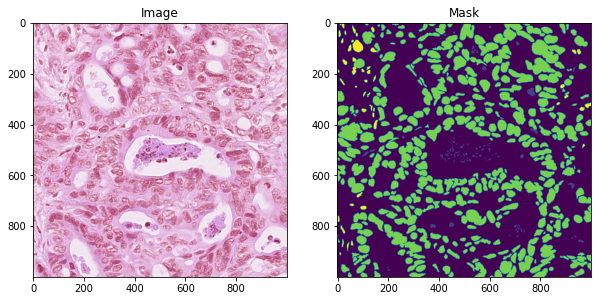

In [20]:
plt.figure(figsize=(10, 30))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(cv2.imread('imgData/Train/Images/train_7.png'))

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask)

# Model

In [21]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

In [22]:
class UNET(nn.Module):
  def __init__(self, in_channels=3, out_channels=8, features=[64, 128, 256, 512],):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Down part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Up part of UNET
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
      self.ups.append(DoubleConv(feature*2, feature))
    
    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]
      
      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])
      
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)
    
    return torch.sigmoid(self.final_conv(x))

# Data Loader

In [23]:
class HoVerNetDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir('imgData/Train/Images/' if "Train" in image_dir else 'imgData/Test/Images/')

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = self.image_dir + str(index+1) + '.png'
    mask_path = self.mask_dir + str(index+1) + '.mat'
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(sio.loadmat(mask_path)['type_map'])

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]
    
    return image, mask

# Training

Utils

In [29]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
  train_ds = HoVerNetDataset(image_dir=train_dir, mask_dir=train_maskdir, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
  val_ds = HoVerNetDataset(image_dir=val_dir, mask_dir=val_maskdir, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

  return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      output = model(x)
      probs = torch.softmax(output, dim=1)
      preds = torch.argmax(probs, dim=1)
      yprim = torch.squeeze(y)
      num_correct += (preds == yprim).sum()
      num_pixels += torch.numel(preds)
  
  print(f"Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f}")
  model.train()

  

Hyperparameters

In [33]:
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMG_HEIGHT = 400
IMG_WIDTH = 400
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = 'imgData/Train/Images/train_'
TRAIN_MASK_DIR = 'imgData/Train/Labels/train_'
VAL_IMG_DIR = 'imgData/Test/Images/test_'
VAL_MASK_DIR = 'imgData/Test/Labels/test_'

Train function

In [34]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    #forward
    with torch.cuda.amp.autocast():
      output = model(data)
      probs = torch.softmax(output, dim=1)
      predictions = torch.argmax(probs, dim=1)
      target = torch.argmax(targets, dim=1)
      loss = loss_fn(output, target)

    #backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    #update tqdm loop
    loop.set_postfix(loss=loss.item())


def main():
  train_transforms = A.Compose(
      [
       A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
       A.Rotate(limit=35, p=1.0),
       A.HorizontalFlip(p=0.5),
       A.VerticalFlip(p=0.1),
       A.Normalize(
           mean=[0.0, 0.0, 0.0],
           std=[1.0, 1.0, 1.0],
           max_pixel_value=255.0,
       ),
       ToTensorV2(),
      ],
  )

  val_transforms = A.Compose(
      [
       A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
       A.Normalize(
           mean=[0.0, 0.0, 0.0],
           std=[1.0, 1.0, 1.0],
           max_pixel_value=255.0,
       ),
       ToTensorV2(),
      ],
  )

  model = UNET(in_channels=3, out_channels=8).to(DEVICE)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  train_loader, val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      VAL_IMG_DIR,
      VAL_MASK_DIR,
      BATCH_SIZE,
      train_transforms,
      val_transforms,
      NUM_WORKERS,
      PIN_MEMORY,
  )

  if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)
    
  check_accuracy(val_loader, model, device=DEVICE)
  scaler = torch.cuda.amp.GradScaler()

  for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)
    # save model ...
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)
    
    #check accuracy
    pred = check_accuracy(val_loader, model, device=DEVICE)



if __name__ == "__main__":
  main()

=> Loading checkpoint
Got 1767232/2240000 with accuracy 78.89


100%|██████████| 2/2 [00:13<00:00,  6.52s/it, loss=2.02]


=> Saving checkpoint
Got 1766399/2240000 with accuracy 78.86


100%|██████████| 2/2 [00:12<00:00,  6.49s/it, loss=1.93]


=> Saving checkpoint
Got 1765297/2240000 with accuracy 78.81


100%|██████████| 2/2 [00:13<00:00,  6.50s/it, loss=1.93]


=> Saving checkpoint
Got 1757709/2240000 with accuracy 78.47


100%|██████████| 2/2 [00:13<00:00,  6.54s/it, loss=1.92]


=> Saving checkpoint
Got 1757145/2240000 with accuracy 78.44


100%|██████████| 2/2 [00:12<00:00,  6.49s/it, loss=1.94]


=> Saving checkpoint
Got 1764655/2240000 with accuracy 78.78


100%|██████████| 2/2 [00:12<00:00,  6.49s/it, loss=1.92]


=> Saving checkpoint
Got 1772956/2240000 with accuracy 79.15


100%|██████████| 2/2 [00:12<00:00,  6.47s/it, loss=1.92]


=> Saving checkpoint
Got 1777277/2240000 with accuracy 79.34


100%|██████████| 2/2 [00:13<00:00,  6.50s/it, loss=1.91]


=> Saving checkpoint
Got 1779647/2240000 with accuracy 79.45


100%|██████████| 2/2 [00:12<00:00,  6.46s/it, loss=1.91]


=> Saving checkpoint
Got 1782687/2240000 with accuracy 79.58


100%|██████████| 2/2 [00:13<00:00,  6.51s/it, loss=1.9]


=> Saving checkpoint
Got 1785956/2240000 with accuracy 79.73


100%|██████████| 2/2 [00:12<00:00,  6.47s/it, loss=1.9]


=> Saving checkpoint
Got 1788451/2240000 with accuracy 79.84


100%|██████████| 2/2 [00:12<00:00,  6.47s/it, loss=1.9]


=> Saving checkpoint
Got 1790773/2240000 with accuracy 79.95


100%|██████████| 2/2 [00:12<00:00,  6.49s/it, loss=1.9]


=> Saving checkpoint
Got 1792681/2240000 with accuracy 80.03


100%|██████████| 2/2 [00:13<00:00,  6.50s/it, loss=1.89]


=> Saving checkpoint
Got 1794358/2240000 with accuracy 80.11


100%|██████████| 2/2 [00:12<00:00,  6.50s/it, loss=1.89]


=> Saving checkpoint
Got 1795812/2240000 with accuracy 80.17


100%|██████████| 2/2 [00:12<00:00,  6.47s/it, loss=1.89]


=> Saving checkpoint
Got 1796869/2240000 with accuracy 80.22


100%|██████████| 2/2 [00:12<00:00,  6.47s/it, loss=1.89]


=> Saving checkpoint
Got 1797781/2240000 with accuracy 80.26


100%|██████████| 2/2 [00:12<00:00,  6.45s/it, loss=1.89]


=> Saving checkpoint
Got 1798427/2240000 with accuracy 80.29


100%|██████████| 2/2 [00:12<00:00,  6.45s/it, loss=1.88]


=> Saving checkpoint
Got 1798916/2240000 with accuracy 80.31


100%|██████████| 2/2 [00:12<00:00,  6.46s/it, loss=1.88]


=> Saving checkpoint
Got 1799303/2240000 with accuracy 80.33
